<a href="https://colab.research.google.com/github/lulli30/TikTok-Influencers-Clustering/blob/main/TikTok_Influencers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Step 1: Load the CSV file containing the top 100 TikTok influencers in 2025
file_path = "Top_100_tiktokers_in_2025.csv"  # Adjust if the filename is different
df = pd.read_csv(file_path)

In [10]:
# Step 2: Display the first few rows of the dataset to inspect its structure
print(df.head())

   Rank         Username  Followers  Following  Uploads        Likes
0     1     Khabane lame  162400000         78     1251   2500000000
1     2  charli d'amelio  155700000       1304     2812  11800000000
2     3          MrBeast  107500000        362      394   1100000000
3     4     Bella Poarch   94300000        649      771   2400000000
4     5      Addison Rae   88500000          1      318   5200000000


In [11]:
# Step 3: Select relevant features for clustering (Followers, Likes, and Uploads)
features = df[['Followers', 'Likes', 'Uploads']]

In [13]:
# Step 4: Normalize the features using StandardScaler to ensure equal weightage
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [17]:
# Step 5: Define a function to find the best eps and min_samples for DBSCAN using grid search
def get_scores_and_labels(combinations, X):
    scores = []
    all_labels_list = []
    N = len(combinations)

    for i, (eps, num_samples) in enumerate(combinations):
        # Apply DBSCAN clustering with current parameter combination
        dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        labels = dbscan_cluster_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)

        # Exclude noise points (-1) from the cluster count
        if -1 in labels_set:
            num_clusters -= 1

        # Step 6: Ignore parameter combinations that result in too few or too many clusters
        if (num_clusters < 2) or (num_clusters > 50):
            scores.append(-10)  # Assign a low score to bad combinations
            all_labels_list.append('bad')
            print(f"Combination {(eps, num_samples)} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
            continue

        # Compute silhouette score to evaluate cluster quality
        # Replace ss with silhouette_score
        scores.append(silhouette_score(X, labels))
        all_labels_list.append(labels)
        print(f"Index: {i}, Score: {scores[-1]}, NumClusters: {num_clusters}")

    # Step 7: Find the best parameter combination based on the highest silhouette score
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_list[best_index]
    best_score = scores[best_index]

    return {'best_epsilon': best_parameters[0],
            'best_min_samples': best_parameters[1],
            'best_labels': best_labels,
            'best_score': best_score}

In [18]:
# Step 8: Define a range of eps and min_samples values to test in grid search
eps_values = np.linspace(0.1, 2, 20)  # Testing different eps values
min_samples_values = range(3, 10)  # Testing different min_samples values
combinations = list(product(eps_values, min_samples_values))  # Generate all parameter combinations

In [19]:
# Step 9: Run grid search to find the best eps and min_samples for DBSCAN
best_dict = get_scores_and_labels(combinations, scaled_features)
best_eps = best_dict['best_epsilon']
best_min_samples = best_dict['best_min_samples']

# Print the best parameters found
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}")

Index: 0, Score: -0.21613537619454776, NumClusters: 5
Index: 1, Score: -0.19740789611269124, NumClusters: 2
Index: 2, Score: -0.24814931007250204, NumClusters: 2
Index: 3, Score: -0.2776800192637978, NumClusters: 2
Combination (0.1, 7) on iteration 5 of 140 has 1 clusters. Moving on
Combination (0.1, 8) on iteration 6 of 140 has 0 clusters. Moving on
Combination (0.1, 9) on iteration 7 of 140 has 0 clusters. Moving on
Index: 7, Score: 0.06027550396424543, NumClusters: 8
Index: 8, Score: -0.0503096782022091, NumClusters: 4
Index: 9, Score: -0.06706279008465767, NumClusters: 2
Index: 10, Score: -0.09334491060482705, NumClusters: 2
Combination (0.2, 7) on iteration 12 of 140 has 1 clusters. Moving on
Combination (0.2, 8) on iteration 13 of 140 has 1 clusters. Moving on
Combination (0.2, 9) on iteration 14 of 140 has 1 clusters. Moving on
Index: 14, Score: 0.29304950848070316, NumClusters: 2
Index: 15, Score: 0.2833292525136666, NumClusters: 2
Index: 16, Score: 0.17514940409798666, NumClus

In [26]:
# Step 10: Run DBSCAN with the optimized eps and min_samples
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df['Cluster'] = dbscan.fit_predict(scaled_features)

In [27]:
# Step 11: Display the number of influencers in each cluster
print(df['Cluster'].value_counts())

Cluster
 0    66
-1    18
 1    16
Name: count, dtype: int64


In [28]:
# Step 12: Identify outliers (Cluster -1) and display their details
outliers = df[df['Cluster'] == -1]
print("Outliers:")
print(outliers[['Username', 'Followers', 'Likes', 'Uploads']])

Outliers:
           Username  Followers        Likes  Uploads
0      Khabane lame  162400000   2500000000     1251
1   charli d'amelio  155700000  11800000000     2812
2           MrBeast  107500000   1100000000      394
3      Bella Poarch   94300000   2400000000      771
4       Addison Rae   88500000   5200000000      318
6   Kimberly Loaiza   83100000   4100000000     2070
8          domelipa   76700000   5000000000     2408
14     Jason Derulo  652200000   1300000000     1007
20            dixie   55400000   3300000000      879
24       Loren Gray   53500000   3000000000     3308
30             ESPN   49500000   6400000000    31600
33     Carlos Feria  468000003   2600000000     5906
38          Netflix   44700000   1200000000     6978
42         omari.to   43600000    479100000     5952
44         Katteyes   42900000   3300000000     1189
46  Barstool Sports   42700000   8200000000     6971
71      ondy mikula   36600000    594800000    13200
98   Faisal shaikh     3200000   200

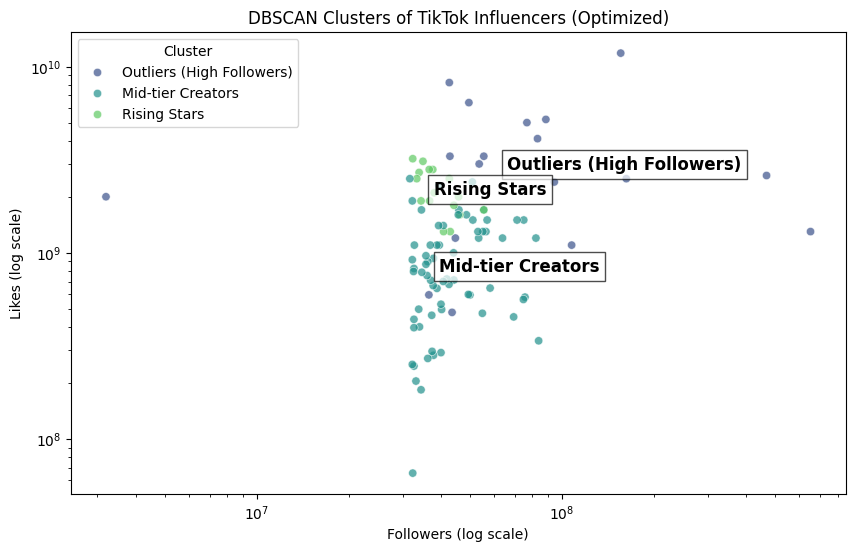

In [29]:
# Step 13: Define meaningful cluster labels
cluster_labels = {
    -1: "Outliers (High Followers)",   # Influencers with significantly high followers
    0: "Mid-tier Creators",            # Influencers with moderate followers and engagement
    1: "Rising Stars"                  # Influencers with fewer followers but high engagement growth
}

# Assign cluster labels based on mapping
df['Cluster_Label'] = df['Cluster'].map(cluster_labels).fillna(df['Cluster'].astype(str))

# Step 14: Visualize clusters with meaningful labels
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x=df['Followers'], y=df['Likes'], hue=df['Cluster_Label'], palette='viridis', alpha=0.7)

# Annotate each cluster with its label
for cluster_num, label in cluster_labels.items():
    cluster_subset = df[df['Cluster'] == cluster_num]
    if not cluster_subset.empty:
        plt.text(
            cluster_subset['Followers'].median(),
            cluster_subset['Likes'].median(),
            label,
            fontsize=12, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7)
        )

# Step 15: Improve visualization using log scale for better clarity
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Followers (log scale)")
plt.ylabel("Likes (log scale)")
plt.title("DBSCAN Clusters of TikTok Influencers (Optimized)")
plt.legend(title="Cluster")
plt.show()